In [1]:
from os import listdir
from os.path import isfile, join
from PIL import Image

import random
import math
import time
import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torchvision.models.segmentation
import torch
import torchvision.transforms as tf
import torch.nn as nn
import torch.nn.functional as F

In [2]:
Learning_Rate = 0.000004
width = 120
height = 120
batchSize = 2900
epochs = 50

trainPercentage = 0.8
testPercentage = 0.1
valPercentage = 0.1 

In [3]:
torch.cuda.is_available()

True

In [4]:
path = 'GeneratedImages'
files = [f for f in listdir(path) if isfile(join(path, f))]

#randomise the order of the files list
random.shuffle(files)

In [5]:
len(files)

195976

In [6]:
def LoadRandomImg():
    path = 'GeneratedImages/' + files[random.randrange(0,len(files))]
    image = Image.open(path)
    angle = path.split('_')[1]

    transformImg=tf.Compose([tf.ToPILImage(),tf.Resize((height,width)),tf.ToTensor(),tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) 
    image=transformImg(np.array(image))
    return image, float(angle)

In [7]:
def LoadImg(name):
    path = 'GeneratedImages/' + files[random.randrange(0,len(files))]
    image = Image.open(path)
    angle = path.split('_')[1]

    transformImg=tf.Compose([tf.ToPILImage(),tf.Resize((height,width)),tf.ToTensor(),tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) 
    image=transformImg(np.array(image))
    return image, float(angle)

In [8]:
trainFiles, valFiles, testFiles = np.split(files, [int(len(files)*trainPercentage), int(len(files)*trainPercentage) + int(len(files)*(testPercentage))])
trainFiles = np.ndarray.tolist(trainFiles)
trainFilesNotModified = trainFiles.copy()
valFiles = np.ndarray.tolist(valFiles)
testFiles = np.ndarray.tolist(testFiles)

totalBatches = math.ceil(len(trainFiles)/batchSize)

allBatches = []

for i in range(0,totalBatches):
    batch = []
    for j in range(0,batchSize):
        try:
            fileName = trainFiles[0]
            trainFiles.remove(fileName)
        except:
            fileName = files[random.randrange(0,len(files))]
        batch.append(LoadImg(fileName))
    
    allBatches.append(batch)

trainFiles = trainFilesNotModified

In [9]:
def LoadBatch(i):
    images = torch.zeros([batchSize,3,height,width])
    angles = torch.zeros([batchSize,1])
    for j in range(0,batchSize):
        images[j] = allBatches[i][j][0]
        angles[j] = allBatches[i][j][1]
    return images,angles

In [10]:
def mseTest(set, model, partialSet = True, partialSetPer = 1):
    
    if set == 'test':
        files = testFiles
    elif(set == 'val'):
        files = valFiles
    elif(set == 'train'):
        files = trainFiles
    
    if partialSet:
        random.shuffle(files)
        length = len(files)
        files = files[0:int(length*partialSetPer)]

    error = []

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # Set model to eval mode
    model = model.eval()

    for file in files:
        image, trueAngle = LoadImg(file)

        #image = torch.autograd.Variable(image, requires_grad=False).to(device).unsqueeze(0) # Convert to pytorch
        image = image.to(device).unsqueeze(0)

        with torch.no_grad():
            prediction = model(image)  # Run net

        predAngle = prediction.data.cpu().numpy()

        error.append((trueAngle - predAngle)**2)

    mse = (1/len(testFiles))*(sum(error))

    #print(set + " MSE: ", str(mse[0][0]))
    return mse[0][0]

In [11]:
len(trainFiles)

156780

In [12]:
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.fc = nn.Linear(512, 128)
        
        self.branch_a1 = nn.Linear(128, 32)
        self.branch_a2 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = F.leaky_relu(self.fc(x))

        a = F.leaky_relu(self.branch_a1(x))
        
        out1 = self.branch_a2(a)
        
        return out1

In [13]:
#load net
#To Load Pretrained Weights:   weights='ResNet18_Weights.DEFAULT'
resnet18 = torchvision.models.resnet18()
resnet18.fc = nn.Identity()
net_add=net()
model = nn.Sequential(resnet18, net_add)

In [14]:
# Set device GPU or CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 

# load model to GPU
model = model.to(device)

# Create optimizer
optimizer = torch.optim.Adam(params=model.parameters(),lr=Learning_Rate) 

# Save average loss for display
losses=np.zeros([epochs]) 

currentBatch = 0
max = len(allBatches)*epochs

mseAtEpochForVal = []
epochArr = []

tStart = time.time()
saveStr = ''

for epoch in range(0,epochs):
    print(f'Starting Epoch: {str(epoch)}')
    t = time.time()

    for batch in range(0,len(allBatches)-1):
        # Load taining batch
        images,angles = LoadBatch(batch)
        
        # Load image and send to device
        images = images.to(device)

        # Load GT and send to device
        angles = angles.to(device)
        
        # set model to training mode
        model = model.train()

        # Make prediction
        predLevels = model(images)
        model.zero_grad()

        # Calculate loss
        loss = torch.nn.L1Loss()
        output = loss(predLevels, angles)

        # Backpropogate loss
        output.backward()
        
        # Apply gradient descent change to weight
        optimizer.step() 

    # copy training files for next epoch  (TODO make this better)
    trainFiles = trainFilesNotModified.copy()

    #val MSE
    mseForEpoch = mseTest('val', model)
    
    epochArr.append(epoch)

    # Save loss
    losses[epoch]=output.data.cpu().numpy()

    #compare model against previous MSE values, save model if better than previous best
    if epoch > 0:
        if mseForEpoch < min(mseAtEpochForVal):
            modelPath = 'bestModel.torch'
            saveStr = f'    Saving New Best Model With MSE Of: {str(mseForEpoch)}\n'
            torch.save(model.state_dict(),   modelPath)
        else:
            saveStr = ''

    mseAtEpochForVal.append(mseForEpoch)

    #TTR
    elapsed = time.time() - t
    print(f'TTR Epoch for {epoch+1} of {epochs}: {str(round(elapsed))} Seconds')
    print(saveStr)

tEnd = time.time()
elapsed = tEnd - tStart
print("Total TTR: " + str(round(elapsed)) + ' Seconds')

Starting Epoch: 0
TTR Epoch for 1 of 50: 112 Seconds

Starting Epoch: 1
TTR Epoch for 2 of 50: 111 Seconds
    Saving New Best Model With MSE Of: 0.055983644

Starting Epoch: 2
TTR Epoch for 3 of 50: 116 Seconds
    Saving New Best Model With MSE Of: 0.013797648

Starting Epoch: 3
TTR Epoch for 4 of 50: 113 Seconds
    Saving New Best Model With MSE Of: 0.0028072805

Starting Epoch: 4
TTR Epoch for 5 of 50: 114 Seconds
    Saving New Best Model With MSE Of: 0.001061292

Starting Epoch: 5
TTR Epoch for 6 of 50: 113 Seconds
    Saving New Best Model With MSE Of: 0.0005684723

Starting Epoch: 6
TTR Epoch for 7 of 50: 114 Seconds
    Saving New Best Model With MSE Of: 0.0003882923

Starting Epoch: 7
TTR Epoch for 8 of 50: 114 Seconds
    Saving New Best Model With MSE Of: 0.00036820778

Starting Epoch: 8
TTR Epoch for 9 of 50: 112 Seconds
    Saving New Best Model With MSE Of: 0.0003611311

Starting Epoch: 9
TTR Epoch for 10 of 50: 113 Seconds
    Saving New Best Model With MSE Of: 0.00035

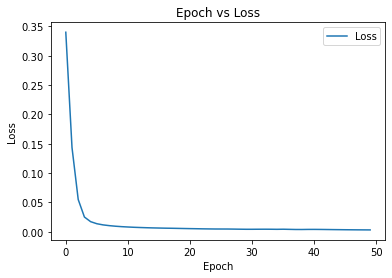

In [15]:
plt.plot(epochArr, losses, label='Loss')

plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

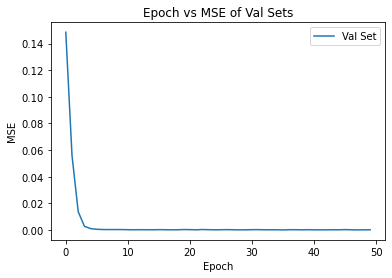

In [16]:
plt.plot(epochArr, mseAtEpochForVal, label='Val Set')

plt.title('Epoch vs MSE of Val Sets')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [17]:
print('Min MSE: ' + str(min(mseAtEpochForVal)))

Min MSE: 9.780353e-05


In [18]:
mseTestSet = mseTest('test', model)
print(mseTestSet)

0.00014880793


In [19]:
image, angle = LoadRandomImg()

#img = torch.autograd.Variable(image, requires_grad=False).to(device).unsqueeze(0) # Convert to pytorch
image = image.to(device).unsqueeze(0)


with torch.no_grad():
    prediction = model(image)  # Run net

print("Predicted Steering Angle: ", prediction.data.cpu().numpy()[0][0])
print("Real Steering Angle: ", angle)
print("Error: ",prediction.data.cpu().numpy()[0][0] - angle)


Predicted Steering Angle:  0.9643264
Real Steering Angle:  0.9611
Error:  0.003226381683349655
